In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

if os.path.abspath(os.path.join(os.getcwd(), "../../")) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
    
from plan_generator.src.data import PlanDataCreator
from plan_generator.src.config import Configuration
from plan_generator.src.enums import LabelsOld, LabelsNew, Colors

In [7]:
# Define a visualizer to check the shape of the data from the RPLAN Dataset 
# https://docs.google.com/forms/d/e/1FAIpQLSfwteilXzURRKDI5QopWCyOGkeb_CFFbRwtQ0SOPhEg0KGSfw/viewform
# ./plan_generator/data/label.xlsx

def visualize_one(index_to_visualize: int) -> None:
    """Visualize the RPLAN floor plan data sample

    Args:
        index_to_visualize (int): index to visualize
    """

    data = os.listdir(Configuration.DATA_PATH)
    data_path = os.path.join(Configuration.DATA_PATH, data[index_to_visualize])

    original_image = cv2.imread(data_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    _, axes = plt.subplots(1, 5, figsize=(7 * 5, 7))
    
    # Extract the walls
    exterior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    exterior_walls_mask = (
        (original_image[:, :, 0] == LabelsOld.EXTERIOR_WALL_1.value)
        | (original_image[:, :, 0] == LabelsOld.MAIN_ENTRANCE.value)
        | (original_image[:, :, 1] == LabelsOld.EXTERIOR_WALL_2.value)
    )

    exterior_walls[exterior_walls_mask] = Colors.BLACK.value

    interior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    interior_walls_mask = (
        (original_image[:, :, 1] == LabelsOld.INTERIOR_WALL.value)
        | (original_image[:, :, 1] == LabelsOld.INTERIOR_DOOR.value)
        | (original_image[:, :, 1] == LabelsOld.WALL_IN.value)
    )
    interior_walls[interior_walls_mask] = Colors.BLACK.value

    # Extract the floor boundary 
    floor = np.zeros_like(original_image) + Colors.WHITE.value[0]
    floor[exterior_walls_mask] = Colors.BLACK.value
    _, floor, _, _ = cv2.floodFill(floor, mask=None, seedPoint=(0, 0), newVal=(0, 0, 0))
    floor = abs(Colors.WHITE.value[0] - floor)
    floor[exterior_walls_mask] = Colors.BLACK.value

    binary_floor = np.zeros((floor.shape[0], floor.shape[1], 1))
    binary_floor[floor[:, :, 0] == 0] = 1

    walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    walls[exterior_walls_mask] = Colors.BLACK.value
    walls[interior_walls_mask] = Colors.BLACK.value

    binary_walls = np.zeros((walls.shape[0], walls.shape[1], 1))
    binary_walls[walls[:, :, 0] == 0] = 1

    channel_1_rooms = np.zeros(shape=(original_image.shape[0], original_image.shape[1], 1))
    channel_3_rooms = np.zeros_like(original_image) + Colors.WHITE.value[0]

    room_types = np.unique(original_image[:, :, 1])
    for room_type in room_types:
        room_color = Colors.COLOR_MAP_OLD.value.get(room_type)
        if room_color is not None:
            room_mask = original_image[:, :, 1] == room_type
            channel_3_rooms[room_mask] = room_color
            channel_1_rooms[room_mask] = LabelsNew.CLASS_MAP.value[room_type]

    components = [
        floor, 
        binary_floor, 
        walls, 
        channel_3_rooms, 
        channel_1_rooms,
        
    ]
    
    titles = [
        "floor", 
        "binary_floor", 
        "binary_walls", 
        "rooms", 
        "room_labels",
    ]

    for ax, component, title in zip(axes.flatten(), components, titles):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("\n\n" + title + "\n\n", fontsize=23)
        ax.axis("off")
        ax.imshow(component)

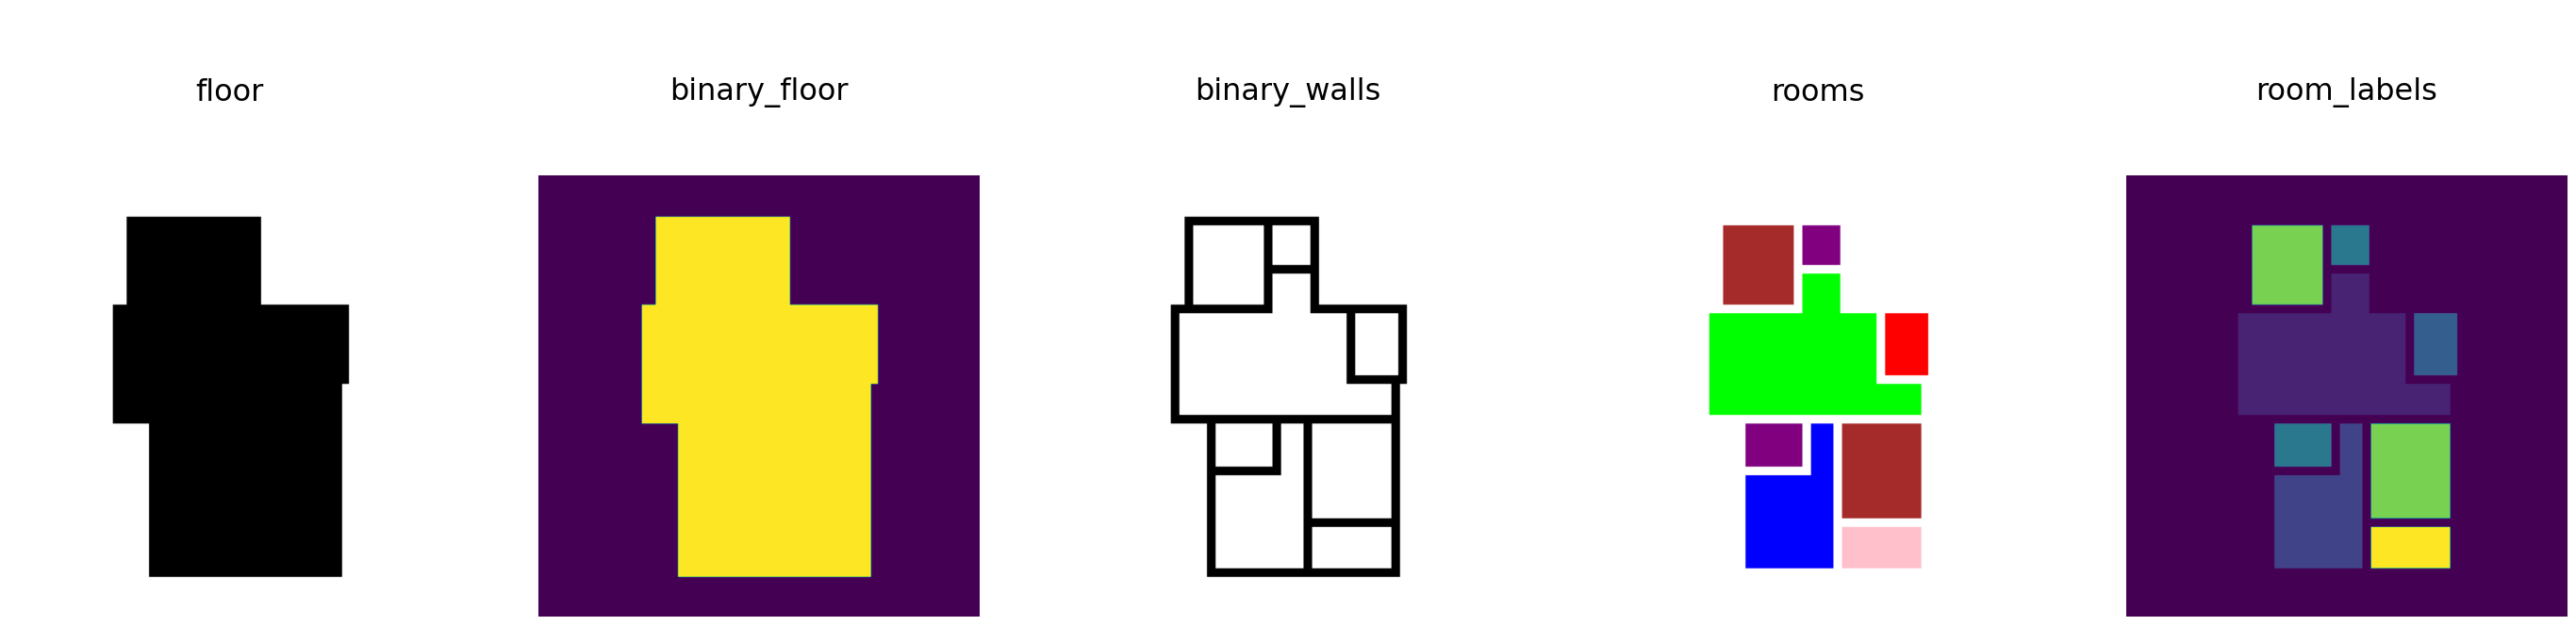

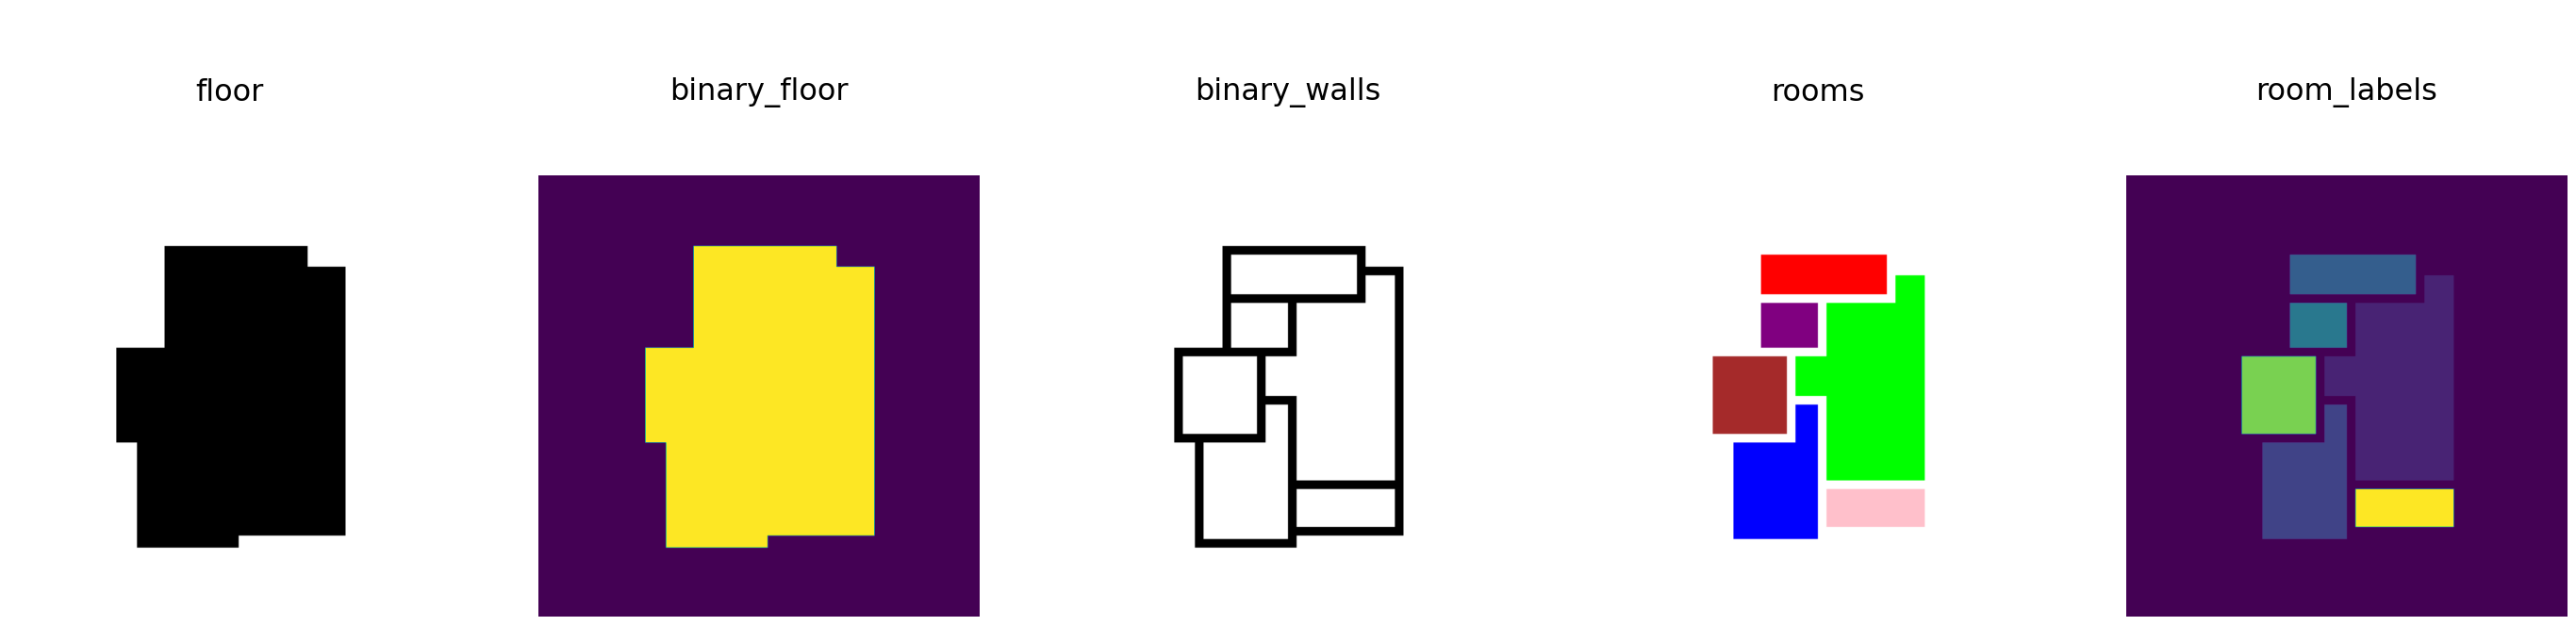

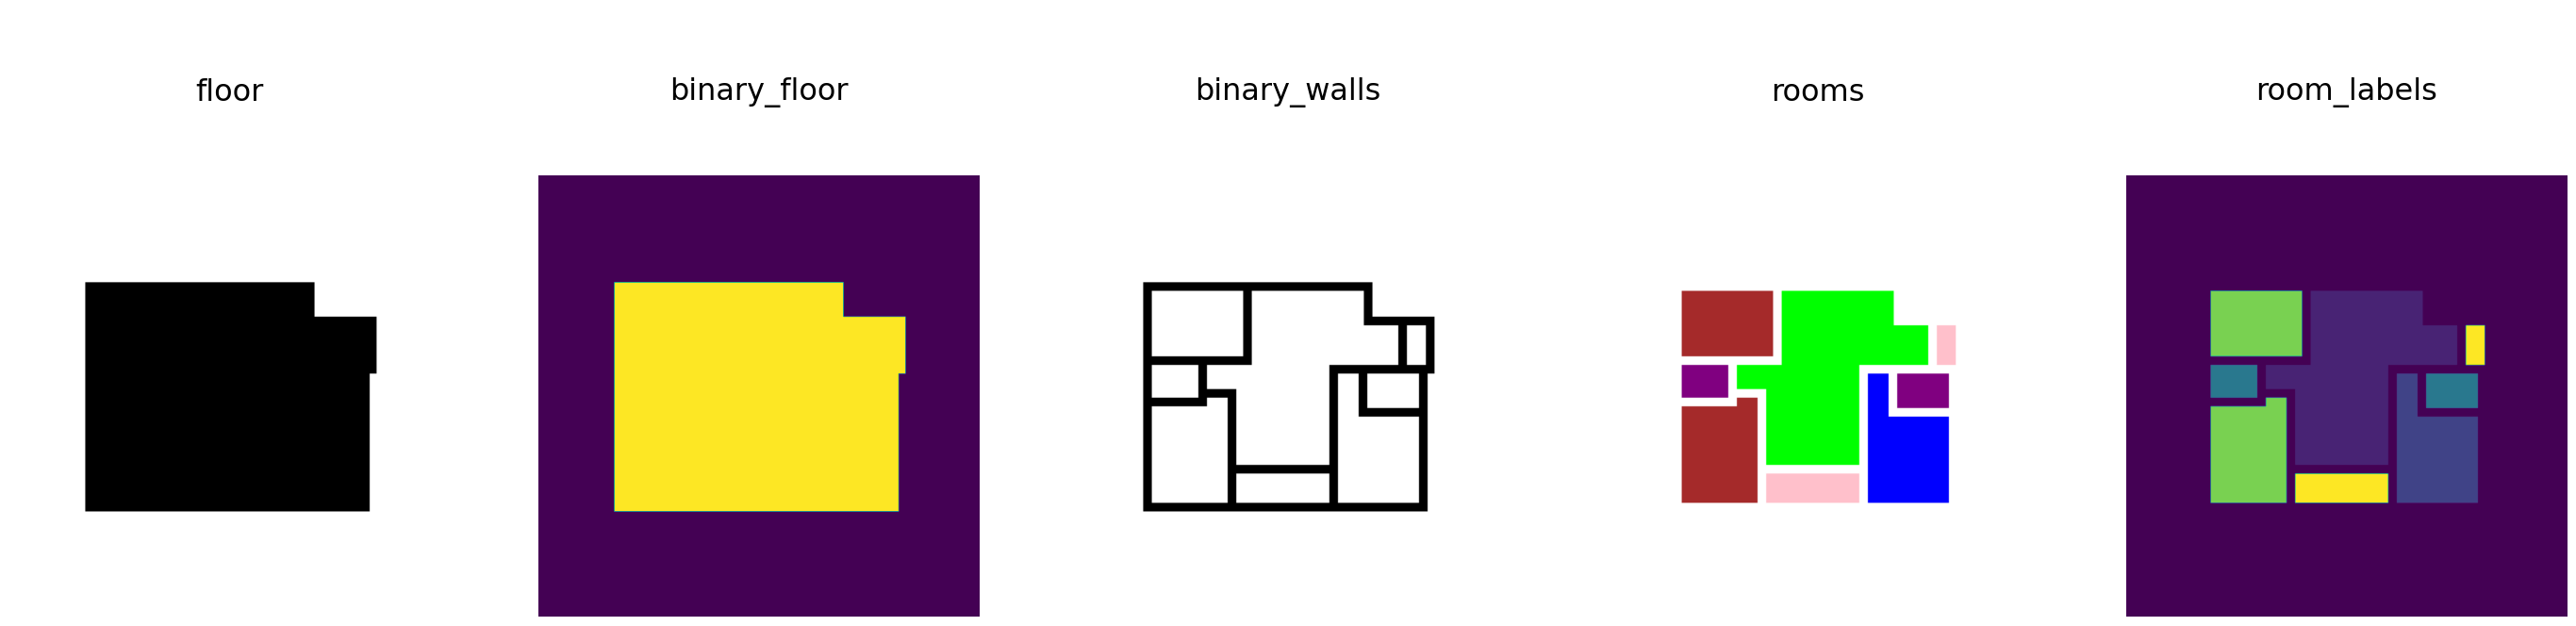

In [13]:
# Visualize data samples from the RPLAN dataset

indices_to_visualize = [7, 77, 777]
for index_to_visualize in indices_to_visualize:
    visualize_one(data_index=index_to_visualize)

In [2]:
# Preprocess data

data_creator = PlanDataCreator()
data_creator.create()

Processing data ...
Processing is done !
The function create took 389.4955246448517 seconds to run.
